# How far is the closest Ikea?

This is a little data science toy project that originated from a walk in the park and the following thought: 

Living in Flagstaff, Arizona, the closest Ikea is located in Tempe, which is a two hour one-way drive. *Is this a short distance by American standards? What percentage of US Americans have a shorter or longer drive to get their 2x2 Kallax shelf unit*? 


## Analysis

In order to address the aforementioned questions, we can map a function that calculates the distance to the closest Ikea location on the United States and weight the distance distribution with the population density distribution. 

We need the following data for this task:
1. *a map of the United States*
2. *a list of all Ikea locations in the States*, possibly with latitudes and longitudes of each location
3. a grid of points within the borders of the US that allows us to derive the *distance to the closest Ikea location for each point on the grid*
4. *the geographic population density distribution across the States*

Putting all these things together, we can derive a *distribution of the distance to the closest Ikea per capita*. 

For the sake of simplicity, we will only consider the continental US in this study. There is actually no Ikea location in either Alaska nor Hawai'i nor any of the US territories. Hence, including either of these states or territories would significantly skew the results of this analysis.

### 1.  We need a map

[cartopy](https://github.com/SciTools/cartopy) seemed like a good way to obtain the map data that we need for this study:

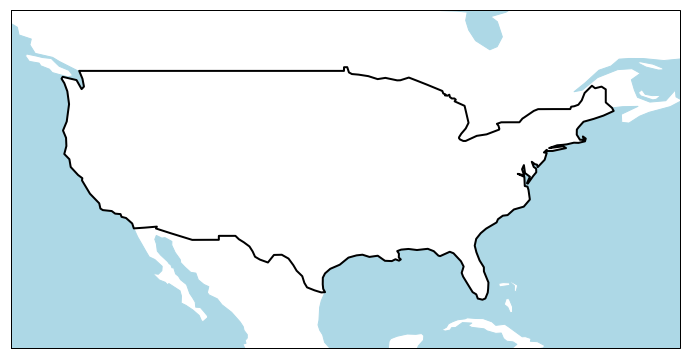

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings 
warnings.simplefilter('ignore', RuntimeWarning)

# define crop area on the globe for this study
# [lon_min, lon_max, lat_min, lat_max]
map_crop = [-130, -60, 20, 50]

def basemap():
    """this function defines a matplotlib axis with a basemap that
    will be used several times in this notebook"""
    f, ax = plt.subplots(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(map_crop)  # define map crop
    ax.add_feature(cfeature.LAND, color='white')  # add land
    ax.add_feature(cfeature.OCEAN, color='lightblue')  # add oceans
    return ax

# read map files from naturalearthdata.com
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

# extract US data from the map files
countries = shpreader.Reader(shpfilename).records()
for country in countries:
    if country.attributes['ABBREV'] == 'U.S.A.':
        us_geometry = country.geometry
        us_shape = country._shape
        break
        
# plot a simple map        
ax = basemap()
ax.add_geometries(us_geometry, ccrs.PlateCarree(), edgecolor='black',
                  facecolor='none', linewidth=2,
                  label=country.attributes['ABBREV'])        

While this a very simple map, it will be sufficient for our purposes. Note that this map does not include lakes, like for instance the Great Lakes. This is a small detail we should keep in mind for later.

### 2. We need a list of Ikea locations in the US

This information is luckily provided by Ikea itself. Just go to [ikea.com](https://ikea.com), and you will get a list of their locations. With a little bit of digging through their javascript files, you can even extract a list of geographic coordinates for their locations, which are compiled below.

In [2]:
import numpy as np

ikea_locations = np.rec.array(
    [('Tempe', 33.3406452 , -111.9701824 ),
     ('Burbank', 34.174558  , -118.303142  ),
     ('Carson', 33.84179776, -118.26031208),
     ('Costa Mesa', 33.69092406, -117.91640997),
     ('Covina', 34.07422161, -117.87920237),
     ('East Palo Alto', 37.4610567 , -122.139374  ),
     ('Emeryville', 37.8310722 , -122.2923363 ),
     ('San Diego', 32.7800402 , -117.1263976 ),
     ('West Sacramento', 38.5866091 , -121.5535246 ),
     ('Centennial', 39.571952  , -104.8750419 ),
     ('New Haven', 41.2961069 ,  -72.9198649 ),
     ('Jacksonville', 30.332184  ,  -81.655651  ),
     ('Miami', 25.7915476 ,  -80.3838211 ),
     ('Orlando', 28.4830125 ,  -81.427288  ),
     ('Sunrise', 26.121522  ,  -80.3317868 ),
     ('Tampa', 27.9539394 ,  -82.4317366 ),
     ('Atlanta', 33.7887958 ,  -84.4052785 ),
     ('Bolingbrook', 41.7279305 ,  -88.0378324 ),
     ('Schaumburg', 42.0568612 ,  -88.0361715 ),
     ('Fishers', 39.954334  ,  -86.0120759 ),
     ('Merriam', 39.019697  ,  -94.6909241 ),
     ('Baltimore', 39.3753398 ,  -76.4616532 ),
     ('College Park', 39.0208564 ,  -76.9285061 ),
     ('Stoughton', 42.1375763 ,  -71.0685603 ),
     ('Canton', 42.324824  ,  -83.4516619 ),
     ('Twin Cities', 44.8584007 ,  -93.2448277 ),
     ('St. Louis', 38.6331482 ,  -90.2440372 ),
     ('Las Vegas', 36.0689264 , -115.280825  ),
     ('Elizabeth', 40.6751301 ,  -74.1697393 ),
     ('Paramus', 40.9245349 ,  -74.0732861 ),
     ('Brooklyn', 40.6719755 ,  -74.0114608 ),
     ('Long Island', 40.7741334 ,  -73.5305931 ),
     ('Charlotte', 35.2933918 ,  -80.7650555 ),
     ('Columbus', 40.1485005 ,  -82.9676117 ),
     ('West Chester', 39.3154678 ,  -84.4339977 ),
     ('Portland', 45.5712882 , -122.5535108 ),
     ('Conshohocken', 40.0951758 ,  -75.3063721 ),
     ('Philadelphia', 39.9170912 ,  -75.141859  ),
     ('Pittsburgh', 40.4518981 ,  -80.1679925 ),
     ('Memphis', 35.1899914 ,  -89.7993025 ),
     ('Frisco', 33.093868  ,  -96.8212207 ),
     ('Grand Prairie', 32.689824  ,  -97.02212   ),
     ('Houston', 29.7854269 ,  -95.4722835 ),
     ('Round Rock', 30.5569728 ,  -97.6902621 ),
     ('Draper', 40.508693  , -111.893237  ),
     ('Woodbridge', 38.6432536 ,  -77.289176  ),
     ('Renton', 47.4424256 , -122.2256924 ),
     ('Oak Creek', 42.88585   ,  -87.863136  )],
     dtype=[('index', 'O'), ('lat', '<f8'), ('lon', '<f8')])

Let's put these locations on the map as black circles and add Flagstaff as a green star:

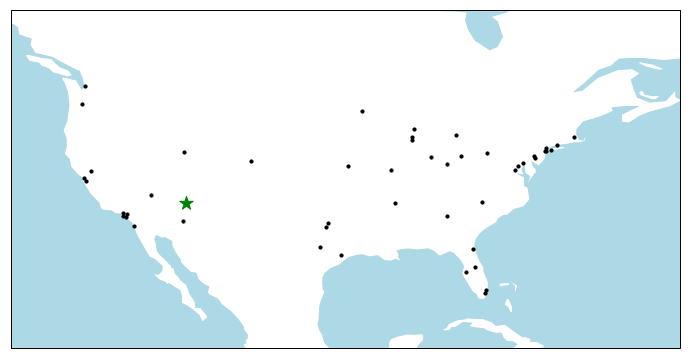

In [3]:
ax = basemap()
ax.scatter(ikea_locations['lon'], ikea_locations['lat'], color='black', marker='o', s=10)  # add Ikeas
ax.scatter(-111.631111, 35.199167, color='green', marker='*', s=200)  # add Flagstaff

There are strong clusters of Ikea locations on the East coast and the West coast, whereas most of the western states seem to be abandoned. Let's put a grid on the US and check the distance to the closest Ikea location. What is the maximum distance from any location in the US to the closest Ikea?

### 3. The distance to the closest Ikea location from any point in the US

The tasks seems simple: create a grid of equidistant or equiangular cells within the borders of the States. The problem is: how to define the borders? 

Here, `cartopy` comes in handy. When we obtained the map information from [naturalearthdata.com](https://www.naturalearthdata.com/) using `cartopy`, we extracted a shapefile for the US, which contains information on its borders, and named this object `us_shape`. 

Now, we can check for each cell of our grid, whether this cell is located within the borders of the US. To make this check, we use functionality from the [shapely](https://github.com/Toblerity/Shapely) module, which can directly use the shapefile information provided in `us_shape`, and put this into the function `in_country`. In order to speed up this process, we `vectorize` this function and apply it to an equiangular grid that covers the area defined by `map_crop`, i.e., the area covered by the map plot shown here.

The result is a boolean `mask` array, defining for each cells whether it is part of the US (`True`), or not (`False`).


In [4]:
from shapely.geometry import Point, shape

def in_country(lon, lat):
    """check whether coordinate pairs lies within the borders of the US"""
    return shape(us_shape).contains(Point(lon, lat))

# build grid
xx, yy = np.mgrid[map_crop[0]:map_crop[1]:300j, map_crop[2]:map_crop[3]:150j]

# mask areas outside the US
mask = np.vectorize(in_country)(xx.ravel(), yy.ravel()).reshape(xx.shape)

We plot this mask on the map plot created by `basemap` to check whether it is consistent with the border outlines shown above:

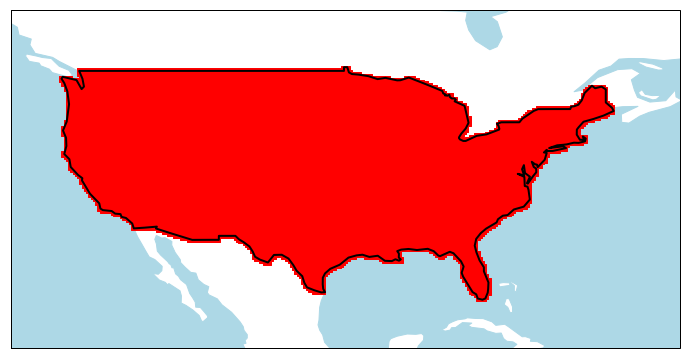

In [5]:
ax = basemap()

# plot mask (only areas within the borders)
ax.scatter(xx[mask], yy[mask], color='red', marker='s', s=30)

# add border lines
ax.add_geometries(us_geometry, ccrs.PlateCarree(), edgecolor='black',
                  facecolor='none', linewidth=2,
                  label=country.attributes['ABBREV']) 

That's good enough the purpose of this study. Now, we just have to find a way to calculate the distance between two points, where the first point is any of the grid cells shown above and the second point is the closest Ikea location. This is an easy task for a [Ball Tree](https://sklearn.org/modules/generated/sklearn.neighbors.BallTree.html) algorithm. 

Keep in mind that this map is a projection from a spherical surface. To find the distance between two points on a sphere, we can make use of the [Haversine](https://en.wikipedia.org/wiki/Versine#Haversine) function and set this as our distance metric.

In [6]:
from sklearn.neighbors import BallTree

# build a tree containing Ikea locations
ikea_tree = BallTree(list(zip(np.deg2rad(ikea_locations.lat),
                              np.deg2rad(ikea_locations.lon))),
                     metric='haversine')

# derive the distances and indices of the closest Ikea locations
# for each point in our grid
match_dist, match_id = ikea_tree.query(list(zip(np.deg2rad(yy.ravel()),
                                                np.deg2rad(xx.ravel()))))
match_dist = match_dist.reshape(xx.shape)*6371  # reshape and convert distances to km
print('maximum distance to Ikea in km:', np.max(match_dist[mask]))

maximum distance to Ikea in km: 1050.6663178983786


The maximum distance from anywhere in the continental US to the closest Ikea is 1050 km. That's a long drive. But where would you have to live to be that far away from the closest Ikea?

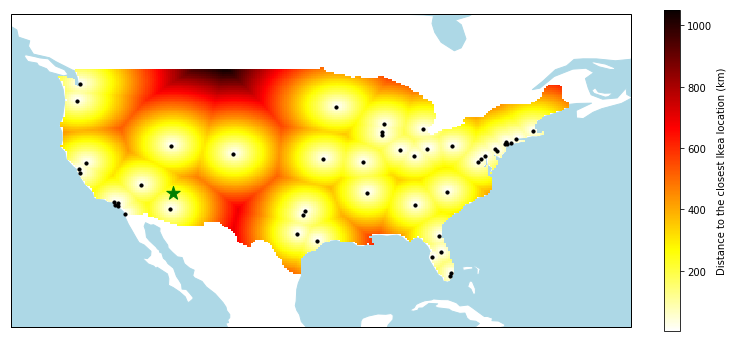

In [7]:
ax = basemap()

# mask areas outside the country borders
match_dist[~mask] = np.nan

# plot the distance map
grid_plot = ax.pcolor(xx, yy, match_dist, snap=True, cmap='hot_r')
ax.scatter(ikea_locations['lon'], ikea_locations['lat'], color='black', marker='o', s=10)  # add Ikea location
ax.scatter(-111.631111, 35.199167, color='green', marker='*', s=200)  # add Flagstaff
plt.colorbar(grid_plot, label='Distance to the closest Ikea location (km)', ax=ax, fraction=0.024, pad=0.05) 

Well, I guess you shouldn't live in Montana if you are a big Ikea fan. This is where you would have to drive the maximum distance of 1050 km to get to the next location. 

### 4. It's the people who matter

So far, we treated every cell in our grid and hence every point in the continental US as equally important. But this is not really the case. Remember the caveat about the map: some areas that are unpopulated (e.g., the Great Lakes) are considered in this map and hence also in our grid. Also, some areas have a much higher population density (e.g., New York City) than others (e.g., Arizona). 

Instead of treating every cell in our grid equally, we should account for the population density distribution if we want to derive useful information on the average distance of US Americans to the closest Ikea. 

#### Census 2010

We can construct an approximation of the population density distribution from [Census 2010](https://en.wikipedia.org/wiki/2010_United_States_Census) data. [This website](https://www.census.gov/geo/reference/centersofpop.html) provides files that list the centers of population on different levels and as a function of geographic coordinates. We download the [population distribution on the "Block Group" level](https://www2.census.gov/geo/docs/reference/cenpop2010/blkgrp/CenPop2010_Mean_BG.txt) (the finest level available) file and map it on our grid. This file basically provides the number of people counted in a "block", as well as the geographic coordinates of the center of this block.

The mapping is done by building a 2-dimensional histogram over the grid from the previous step. By using the population number as weights, this methods basically sums up the population that falls within one grid cell. The result is the total population per map grid cell.

This method is not perfect in that it does not properly sample the population distribution on the very fine scale. Each block is treated as a singularity, whereas in reality, the population counted in this block is spread over a much larger area that might even spread into a neighboring cell. For the sake of simplicity, we will ignore this effect for now.

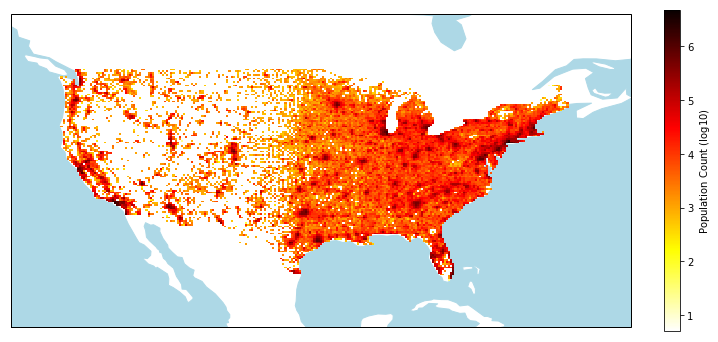

In [8]:
import pandas as pd

# read in population data
# https://www.census.gov/geo/reference/centersofpop.html
pop = pd.read_csv('CenPop2010_Mean_BG.txt')

# build a two-dimensional histogram of the population distribution
pop_grid, pop_xgrid, pop_ygrid = np.histogram2d(
    pop.LONGITUDE, pop.LATITUDE,
    bins=xx.shape,
    range=[[map_crop[0], map_crop[1]], [map_crop[2], map_crop[3]]],
    weights=pop.POPULATION)
pop_grid[~mask] = np.nan  # mask areas outside the country borders

# plot the population density using a logarithmic scale
ax = basemap()
pop_plot = ax.pcolor(xx, yy, np.log10(pop_grid), snap=True, cmap='hot_r')
plt.colorbar(pop_plot, label=r'Population Count ($\log10$)', ax=ax, fraction=0.024, pad=0.05)

While not perfect, this logarithmic map looks like a credible representation of the population density distribution in the US:
* the highly populated areas on the East and West coasts are clearly visible
* the Great Lakes clearly pop out as unpopulated areas
* larger cities in the Midwest are clearly identifiable

On the downside, some areas in the West appear as completely unpopulated, which is a result of the singularized population distribution resulting from the simplistic data format.

## Results: the distance distribution to the closest Ikea per capita

We have all the ingredients in place. Now it's time to calculate the final result: *What is the distribution of distances to Ikea among the population?*

In order to obtain this distribution, we multiply the *distance to the closest Ikea per grid cell* (step 3) with the *population density distribution* (step 4) for each of the grid cells:

In [9]:
dist_pop_hist, dist_pop_bins = np.histogram(match_dist.ravel(), bins=100,
                                            range=(0, np.nanmax(match_dist)),
                                            weights=pop_grid.ravel())

To derive some useful information from this distribution we turn it into a normalized cumulative distribution and interpolate some meaningful distances:

In [10]:
dist_pop_cumhist = np.cumsum(dist_pop_hist)
dist_pop_cumhist /= dist_pop_cumhist[-1]

from scipy.interpolate import interp1d
from scipy.optimize import bisect

# interpolate the distance function (=f_dist)
f_dist = interp1d(dist_pop_bins[:-1]+dist_pop_bins[1]/2, dist_pop_cumhist)

# find the distances at which f_dist equals some meaningful percentages
for p in [50, 10, 90]:
    print('{:.1f}% of US Americans live within {:.1f} km of an Ikea location'.format(
        p, bisect(lambda d: f_dist(d)-p/100, dist_pop_bins[0]+dist_pop_bins[1]/2, dist_pop_bins[-2]+dist_pop_bins[1]/2)))          

50.0% of US Americans live within 60.1 km of an Ikea location
10.0% of US Americans live within 7.7 km of an Ikea location
90.0% of US Americans live within 293.8 km of an Ikea location


Given that the continental US spans about 4000 km from coast to coast, this is a pretty impressive coverage: 50% of US Americans have to drive less than 60 km to get to Ikea. 

Now, of course, the most important question: how does Flagstaff, which has a (straight-line) distance of 206 km to the closest Ikea in Tempe, fare in comparison to these numbers:

In [11]:
print('{:.1f}% of Americans are closer to the closest Ikea than Flagstaff.'.format(f_dist(206)*100))  

79.4% of Americans are closer to the closest Ikea than Flagstaff.


Well, this is demotivating...

Just out of curiosity: where do those ~20% of US Americans live that are worse off than Flagstaff?

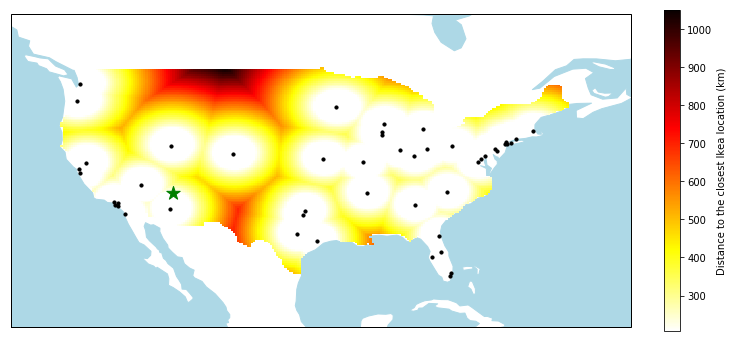

In [12]:
ax = basemap()

# copy the distance distribution and extract only those areas with a larger distance than 206 km
moredistant = match_dist[:]
moredistant[moredistant < 206] = np.nan

# plot the culled distance distribution
grid_plot = ax.pcolor(xx, yy, moredistant, snap=True, cmap='hot_r')
ax.scatter(ikea_locations['lon'], ikea_locations['lat'], color='black', marker='o', s=10)  # add Ikeas
ax.scatter(-111.631111, 35.199167, color='green', marker='*', s=200)  # add Flagstaff
plt.colorbar(grid_plot, label='Distance to the closest Ikea location (km)', ax=ax, fraction=0.024, pad=0.05)

For the sake of completeness, here is the complete cumulative distribution of population-weighted distances:

Text(0,0.5,'Cumulative Fraction of Population')

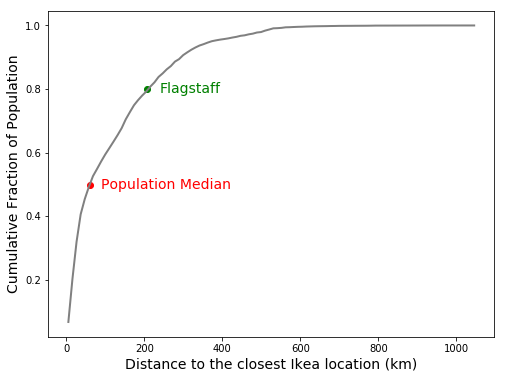

In [13]:
# plot cumulative distribution of distances
f, ax = plt.subplots(figsize=(8,6))
ax.plot(dist_pop_bins[:-1]+(dist_pop_bins[0]+dist_pop_bins[1])/2,
        dist_pop_cumhist/dist_pop_cumhist[-1], lw=2, color='gray')

# label Flagstaff
ax.scatter(206, 0.8, color='green')
ax.annotate('Flagstaff', xy=(240, 0.8), horizontalalignment='left', 
            verticalalignment='center', fontsize=14, color='green')

# label the population median
ax.scatter(60, 0.5, color='red')
ax.annotate('Population Median', xy=(90, 0.5), horizontalalignment='left', 
            verticalalignment='center', fontsize=14, color='red')

# label axes
ax.set_xlabel('Distance to the closest Ikea location (km)', fontsize=14)
ax.set_ylabel('Cumulative Fraction of Population', fontsize=14)



One final question: what fraction of the US population can reach an Ikea within ~3o min to 1 hr, roughly corresponding to a 50 km to 100 km drive?

In [14]:
print('{:.1f}% of Americans live within 50 km of the closest Ikea.'.format(f_dist(50)*100)) 
print('{:.1f}% of Americans live within 100 km of the closest Ikea.'.format(f_dist(100)*100)) 

46.4% of Americans live within 50 km of the closest Ikea.
59.5% of Americans live within 100 km of the closest Ikea.


## Conclusions

* The median distance between (continental) US Americans and the closest Ikea location is 60 km.
* 80% of (continental) US Americans live closer to an Ikea location than people living in Flagstaff.
* 46% to 60% of (continental) US Americans live within a casual drive distance to Ikea.

## Discussion

This study is solid on the large distance scales considered here. If you are interested in a finer grid with cells covering only a few kilometers, a better representation of the population distribution is probably necessary. Similarly, distances considered here are curved lines (on a sphere) and do not consider roadways or traffic. For a more detailed study, roads and traffic should be considered. 

Despite these shortcomings, the results shown here are stable, e.g., with respect to the resolution of the grid used in the mapping. Both larger and smaller cells lead to very similar results. 

## More ideas

It would be interesting to extend this study to other countries and compare their population-weighted distance distributions. My guess is that Europeans have to cross much shorter distances to get to Ikea...

Similary, it would be interesting to project the same concept to other service providers: gas stations, police stations, bars, groceries, churches...